In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PLOTS_FOLDER = "../plots"

RANDOM_SEED = 0

In [3]:
score_df = pd.read_csv(f"../data/tatoeba_train_opus_scores.tsv", sep="\t", index_col=0)

y = score_df.bleu

del score_df

In [4]:
def prep_data(path):
    df = pd.read_csv(path, sep="\t", index_col=0)
    unique_cnts = df.nunique(axis=0)
    const_feats = unique_cnts[unique_cnts == 1]
    df.drop(const_feats.index.tolist(), axis=1, inplace=True)
    return df

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

In [6]:
from sklearn.metrics import r2_score, mean_squared_error

In [7]:
def get_metrics(alphas, X, y):
    X_train, X_test = X
    y_train, y_test = y

    r2s = []
    mses = []

    for alpha in alphas:
        model = Ridge(alpha=alpha).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2s.append(r2_score(y_test, y_pred))
        mses.append(mean_squared_error(y_test, y_pred))

    return np.array(r2s), np.array(mses)

In [8]:
def plot_metrics(thresh, alphas, r2s, mses, additional_info="full"):
    plt.figure(figsize=(8, 6))

    sns.lineplot(x=alphas, y=r2s)

    ax = plt.gca()
    ax.set_xscale("log")
    ax.set(
        xlabel="Regularization coefficient", 
        ylabel="$ R^2 $",
        title=f"Metrics for linear regression\nTopological features, threshold {thresh}, {additional_info}"
    )

    ax.grid()
    ax.get_yaxis().get_major_formatter().set_useOffset(False)

    plt.show()

In [9]:
from functools import partial
from multiprocess.pool import Pool

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [10]:
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
def suppressed_vif(X, idx):
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        return variance_inflation_factor(X, idx)

def calculate_vif_(X, thresh=5.0, verbose=False):
    pool = Pool(processes=8)
    variables = np.array(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif_func = partial(suppressed_vif, X.iloc[:, variables].values)
        args = list(range(X.iloc[:, variables].shape[1]))
        vif = pool.map(vif_func, args)

        vif = np.array(vif)
        if vif.max() > thresh:
            if verbose:
                print("dropping", X.columns[variables[vif == vif.max()]])
            variables = variables[vif < vif.max()]
            dropped = True

    pool.close()
    if verbose:
        print("Remaining variables:")
        print(X.columns[variables])
    return variables

In [12]:
import os
import sys

In [13]:
def train_linreg(path, alphas, n_samples=500):
    X = prep_data(path)

    common_index = X.index.intersection(y.index)

    X_train, X_test, y_train, y_test = train_test_split(X.reindex(common_index), y.reindex(common_index), random_state=RANDOM_SEED, test_size=0.4)
    del X

    used_vars = calculate_vif_(X_train.sample(n_samples))

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    r2s, mses = get_metrics(alphas, (X_train, X_test), (y_train, y_test))
    best_full_r2 = r2s.max()
    plot_metrics(thresh, alphas, r2s, mses, "full")

    r2s, mses = get_metrics(alphas, (X_train[:, used_vars], X_test[:, used_vars]), (y_train, y_test))
    best_cut_r2 = r2s.max()
    plot_metrics(thresh, alphas, r2s, mses, "VIF cut")

    return best_full_r2, best_cut_r2

### Ridge for vanilla topological features

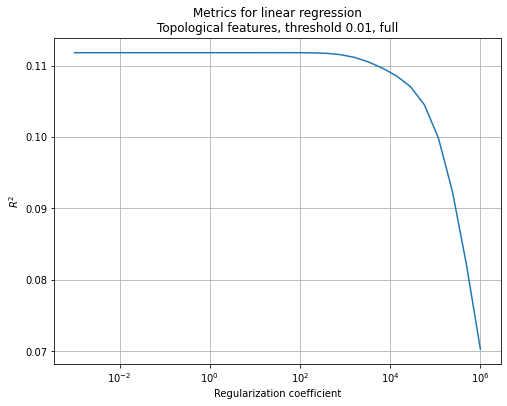

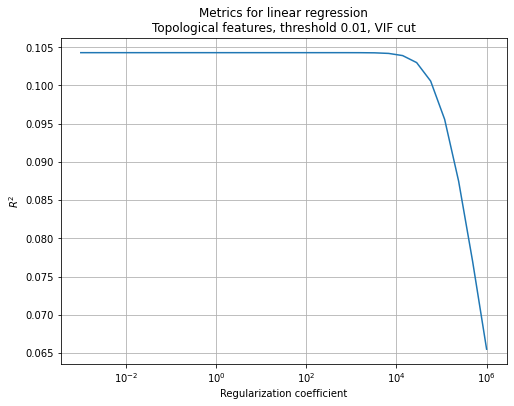

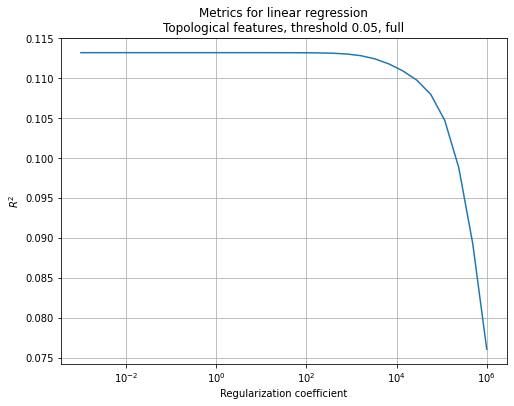

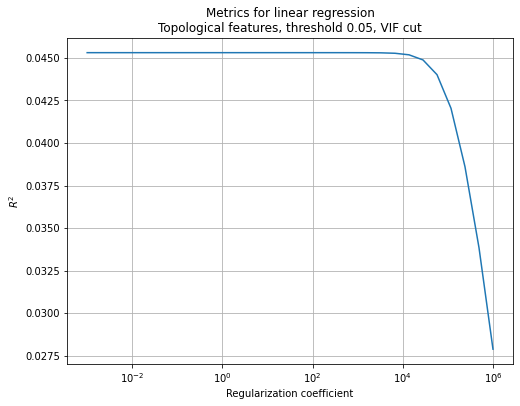

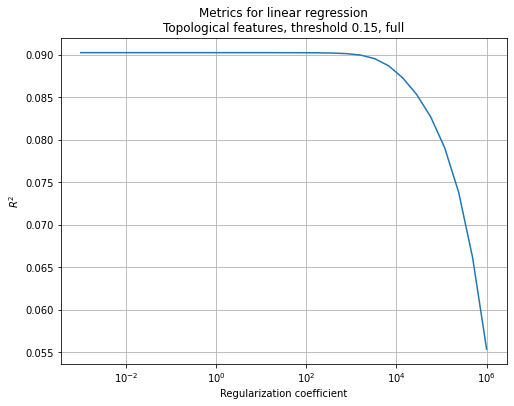

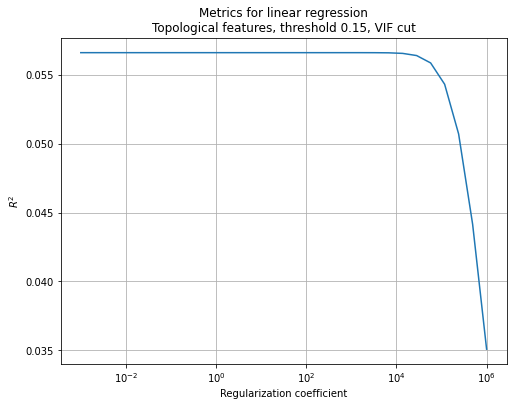

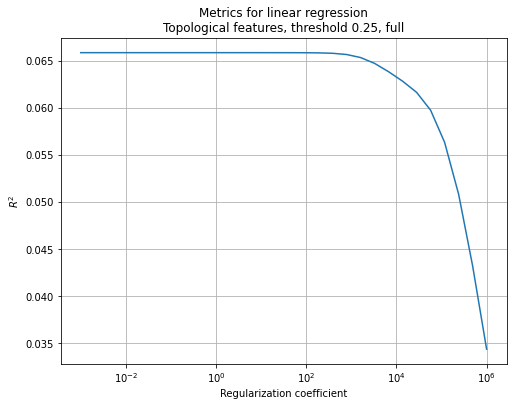

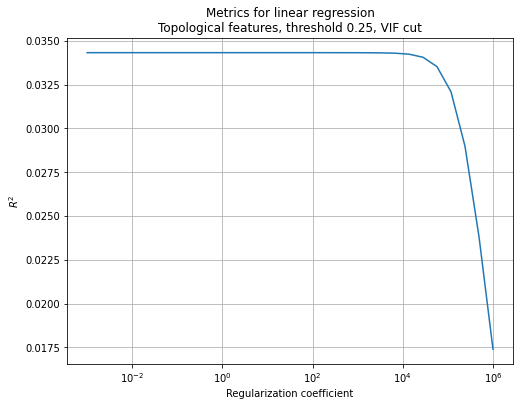

In [14]:
threshs = [0.01, 0.05, 0.15, 0.25]
alphas = np.logspace(-3, 6, num=30)

full_r2s = []
cut_r2s = []

for thresh in threshs:
    full_r2, cut_r2 = train_linreg(f"../data/tatoeba_tf_train_thresh{thresh}.tsv", alphas)
    full_r2s.append(full_r2)
    cut_r2s.append(cut_r2)

In [15]:
def plot_metrics_thresh(threshs, full_r2s, cut_r2s):
    plt.figure(figsize=(8, 12))

    plt.subplot(211)

    sns.lineplot(x=threshs, y=full_r2s)

    ax = plt.gca()
    ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")
    ax.grid()

    plt.subplot(212)

    sns.lineplot(x=threshs, y=cut_r2s)

    ax = plt.gca()
    ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")
    ax.grid()

    plt.show()

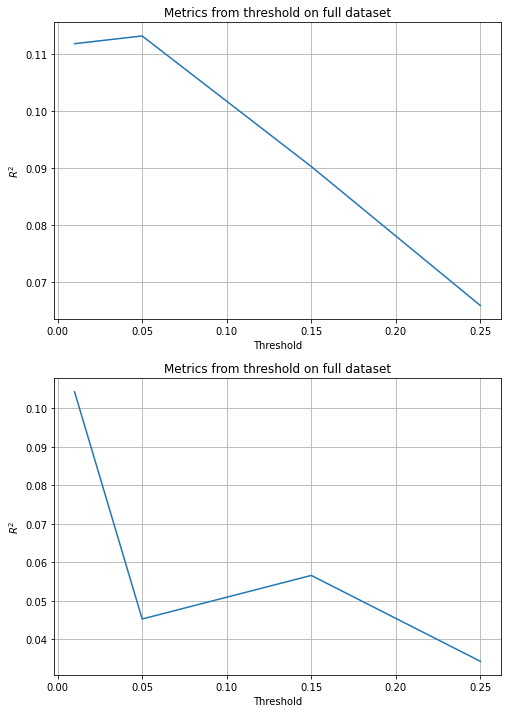

In [16]:
plot_metrics_thresh(threshs, full_r2s, cut_r2s)

In [17]:
from getpass import getpass
import mlflow

os.environ["MLFLOW_TRACKING_USERNAME"] = "no-brainer"
os.environ["MLFLOW_TRACKING_PASSWORD"] = getpass("Enter your DAGsHub access token: ")

mlflow.set_tracking_uri("https://dagshub.com/no-brainer/tda-mt.mlflow")

In [43]:
for i in range(len(threshs)):
    params = {
        "experiment_type": "bleu_prediction",
        "target_path": "../data/tatoeba_train_opus_scores.tsv",
        "train_test_split random_seed": RANDOM_SEED,
        "train_test_split test_size": 0.4,
        "features_path": f"../data/tatoeba_tf_train_thresh{thresh}.tsv",
        "thresh": threshs[i],
    }
    with mlflow.start_run():
        mlflow.log_metric("r2", full_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "full")
    
    with mlflow.start_run():
        mlflow.log_metrics("r2", cut_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "VIF cut")

### Ridge for features without special tokens

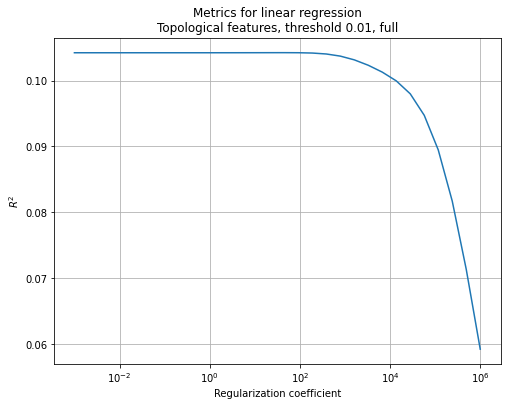

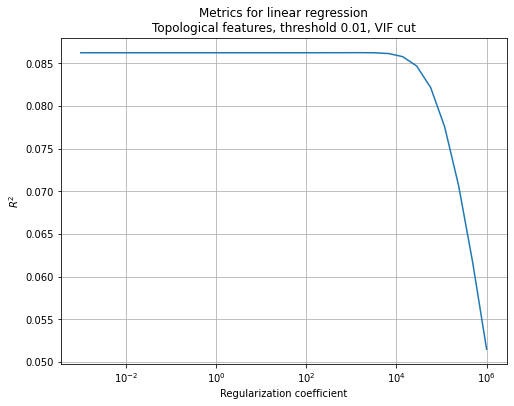

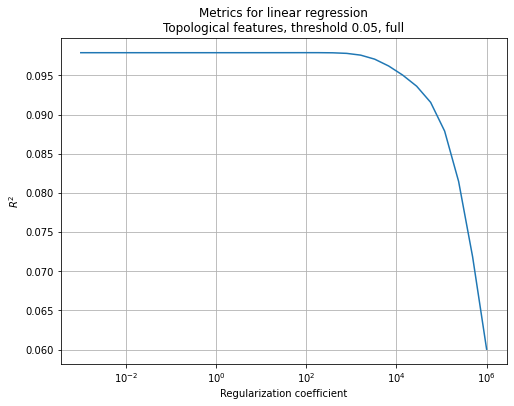

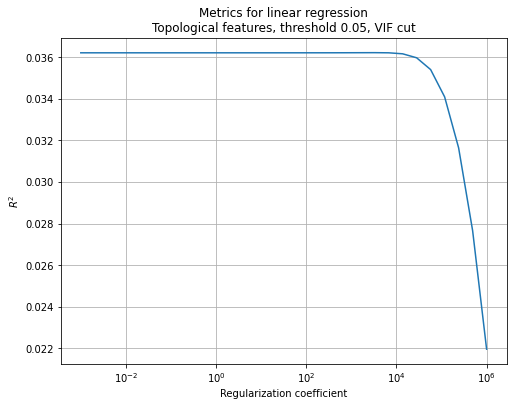

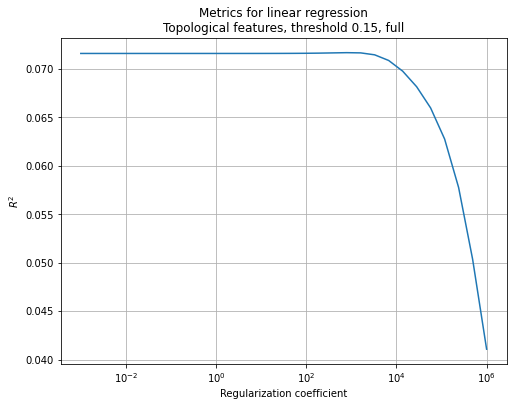

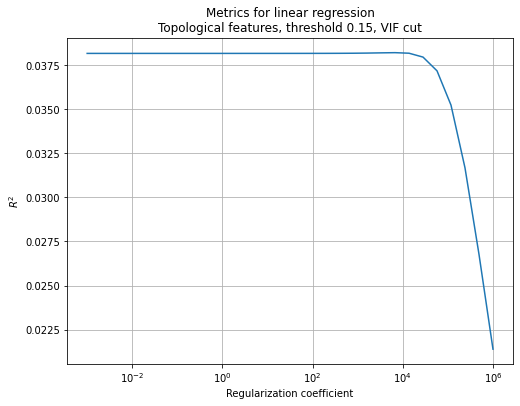

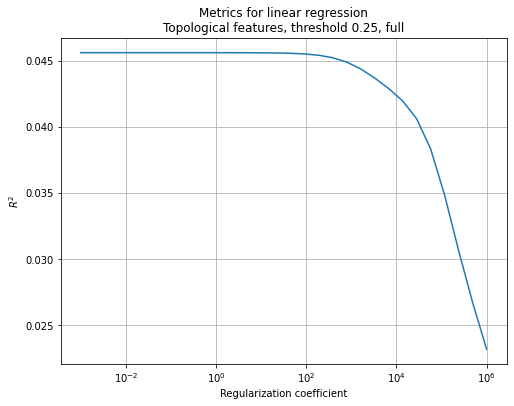

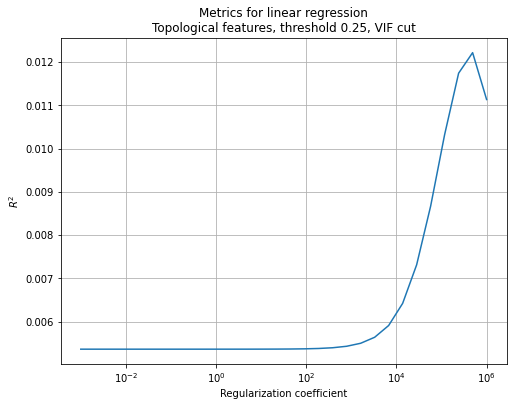

In [19]:
full_r2s = []
cut_r2s = []

for thresh in threshs:
    full_r2, cut_r2 = train_linreg(f"../data/tatoeba_tf_train_no_special_tokens_thresh{thresh}.tsv", alphas)
    full_r2s.append(full_r2)
    cut_r2s.append(cut_r2)

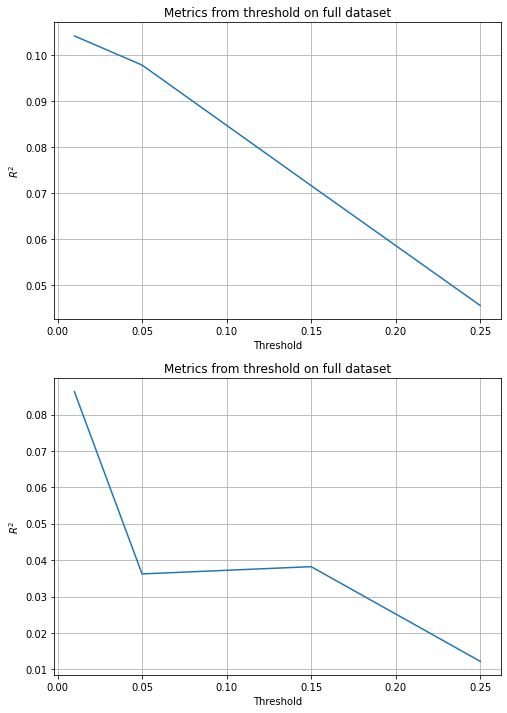

In [20]:
plot_metrics_thresh(threshs, full_r2s, cut_r2s)

In [ ]:
for i in range(len(threshs)):
    params = {
        "experiment_type": "bleu_prediction",
        "target_path": "../data/tatoeba_train_opus_scores.tsv",
        "train_test_split random_seed": RANDOM_SEED,
        "train_test_split test_size": 0.4,
        "features_path": f"../data/tatoeba_tf_train_no_special_tokens_thresh{thresh}.tsv",
        "thresh": threshs[i],
    }
    with mlflow.start_run():
        mlflow.log_metric("r2", full_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "full")
    
    with mlflow.start_run():
        mlflow.log_metrics("r2", cut_r2s[i])
        mlflow.log_param(params)
        mlflow.log_param("data", "VIF cut")

### ElasticNet for vanilla topological features

In [21]:
from sklearn.linear_model import ElasticNet

In [36]:
def get_metrics(alphas, l1_ratios, X, y):
    X_train, X_test = X
    y_train, y_test = y

    r2s = []
    mses = []

    for alpha in alphas:
        for l1_ratio in l1_ratios:
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(X_train, y_train)
            y_pred = model.predict(X_test)
            r2s.append(r2_score(y_test, y_pred))
            mses.append(mean_squared_error(y_test, y_pred))

    shape = (len(alphas), len(l1_ratios))
    return np.array(r2s).reshape(shape), np.array(mses).reshape(shape)

In [37]:
def plot_metrics(thresh, alphas, l1_ratios, r2s, mses, additional_info="full"):
    alphas = list(map(lambda x: f"{x:.2f}", alphas))
    l1_ratios = list(map(lambda x: f"{x:.2f}", l1_ratios))

    plt.figure(figsize=(6, 8))

    scores = pd.DataFrame(r2s, index=alphas, columns=l1_ratios)
    sns.heatmap(scores, square=True)

    ax = plt.gca()
    ax.set(
        xlabel="Regularization coefficient", 
        ylabel="$ R^2 $",
        title=f"Metrics for linear regression\nTopological features, threshold {thresh}, {additional_info}"
    )

    ax.grid()
    plt.show()

In [38]:
def train_linreg(path, alphas, l1_ratios):
    X = prep_data(path)

    common_index = X.index.intersection(y.index)

    X_train, X_test, y_train, y_test = train_test_split(X.reindex(common_index), y.reindex(common_index), random_state=RANDOM_SEED, test_size=0.4)
    del X

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    r2s, mses = get_metrics(alphas, l1_ratios, (X_train, X_test), (y_train, y_test))
    best_full_r2 = r2s.max()
    plot_metrics(thresh, alphas, l1_ratios, r2s, mses, "full")

    return best_full_r2

In [40]:
from sklearn.exceptions import ConvergenceWarning

warnings.simplefilter("ignore", category=ConvergenceWarning)

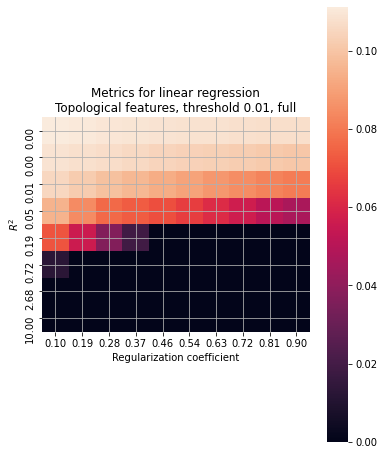

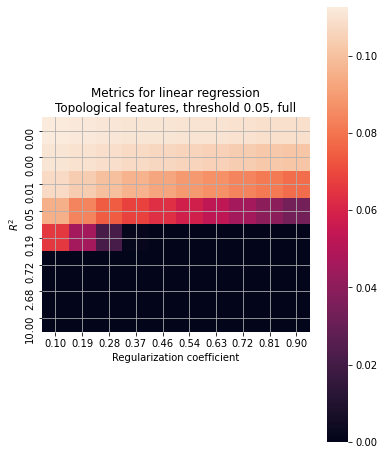

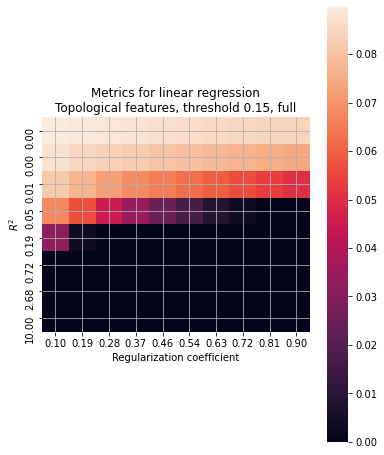

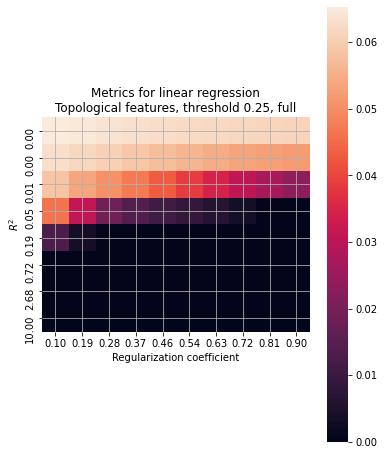

In [41]:
threshs = [0.01, 0.05, 0.15, 0.25]
alphas = np.logspace(-3, 1, num=8)
l1_ratios = np.linspace(0.1, 0.9, num=10)

full_r2s = []

for thresh in threshs:
    full_r2 = train_linreg(f"../data/tatoeba_tf_train_thresh{thresh}.tsv", alphas, l1_ratios)
    full_r2s.append(full_r2)

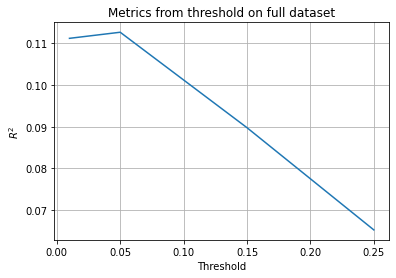

In [42]:
sns.lineplot(x=threshs, y=full_r2s)

ax = plt.gca()
ax.set(xlabel="Threshold", ylabel="$ R^2 $", title="Metrics from threshold on full dataset")
ax.grid()

plt.show()

In [44]:
for i in range(len(threshs)):
    params = {
        "experiment_type": "bleu_prediction",
        "target_path": "../data/tatoeba_train_opus_scores.tsv",
        "train_test_split random_seed": RANDOM_SEED,
        "train_test_split test_size": 0.4,
        "features_path": f"../data/tatoeba_tf_train_thresh{thresh}.tsv",
        "thresh": threshs[i],
    }
    with mlflow.start_run():
        mlflow.log_metric("r2", full_r2s[i])
        mlflow.log_params(params)
        mlflow.log_param("data", "full")